# IMAGE FOLDER NAME

In [1]:
folder_name = "train_gdemo/"
#folder_name = "train_35/"
#folder_name = "train/"

# Precursor (setup/install)

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
!pip -q install tensorflow tensorflow-gpu opencv-python matplotlib keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras import layers
import matplotlib
import pathlib
import cv2
import imghdr
import time
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, load_model # MAY NEED TO BE REPLACED W/ FUNCTIONAL API
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.metrics import Precision, Recall, BinaryAccuracy
from PIL import Image

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # /OOM error

# Global Variables

## image data

In [6]:
size = 512#256#512
img_height, img_width = size,size
image_height, image_width = size, size
data_dir = 'drive/MyDrive/Colab Notebooks/Polyamanita/data/'+folder_name
image_extensions = ['jpg', 'jpeg', 'png'] # every file ends with jpg, but it's found to be a jpeg instead...

## epoch / batch

In [7]:
epochs = 50 # early stops implimented
batch_size = 16#int(size/4)#int(size/4) #16 #32

## train_ds / val_ds

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 12975 files belonging to 20 classes.
Using 10380 files for training.
Found 12975 files belonging to 20 classes.
Using 2595 files for validation.


In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)

# Autotuning

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Create the Model

In [12]:
preprocess_input_mobilenet_v2 = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(size, size, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
base_model.trainable = False
    
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(size, size, 3))

x = data_augmentation(inputs)
x = preprocess_input_mobilenet_v2(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
ckpt_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/'+folder_name
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory,
#                                                  save_weights_only=True,
#                                                  verbose=1,
#                                                  save_freq=3
# )
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=3*(batch_size**2)
)

In [16]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # study more into this
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) # TODO: try this 

# Compile Model

In [17]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Train Model

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback, cp_callback],
)

Epoch 1/50
649/649 [==============================] - 824s 1s/step - loss: 1.6637 - accuracy: 0.5780 - val_loss: 1.1682 - val_accuracy: 0.7588
Epoch 2/50
117/649 [====>.........................] - ETA: 17s - loss: 1.1096 - accuracy: 0.7489
Epoch 2: saving model to drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/train_gdemo/
649/649 [==============================] - 28s 43ms/step - loss: 1.0220 - accuracy: 0.7693 - val_loss: 0.9806 - val_accuracy: 0.8012
Epoch 3/50
237/649 [=========>....................] - ETA: 13s - loss: 0.9521 - accuracy: 0.7795
Epoch 3: saving model to drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/train_gdemo/
649/649 [==============================] - 26s 41ms/step - loss: 0.9047 - accuracy: 0.7952 - val_loss: 0.9204 - val_accuracy: 0.8162
Epoch 4/50
355/649 [===============>..............] - ETA: 9s - loss: 0.8797 - accuracy: 0.8035
Epoch 4: saving model to drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/train_gdemo/
649/649 [================

# Save the Model

In [19]:
model_save = model

In [20]:
# checkpoint = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/'
# for file in os.listdir(checkpoint):
#     os.remove(checkpoint + file)

In [21]:
# i = 1
this = 'FINAL'
model_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/models/'+this # TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [22]:
model.save(model_directory+'/savedmodel')

In [23]:
model.save(model_directory+'/savedmodel.h5')

In [24]:
os.listdir(model_directory)

['savedmodel', 'savedmodel.h5']

In [25]:
# TODO: save class_names into a file ()

# Kill Runtime

# View Performance Graph

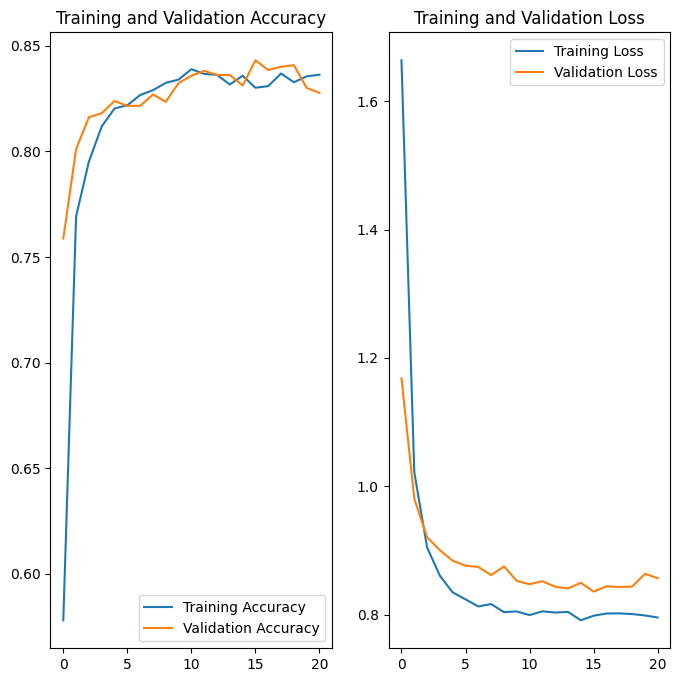

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(21) # callback cucks this

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()